In [6]:
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.3.1

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectFromModel, RFE
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin

In [8]:
df_train = pd.read_csv("train.csv")

In [9]:
df_train.drop(["Patient Id","Patient First Name","Family Name","Father's name","Location of Institute","Institute Name","Place of birth",'Test 1',
       'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Parental consent'],inplace=True,axis=1)

In [10]:
df_train["Birth asphyxia"] = df_train["Birth asphyxia"].replace("No record",np.nan)
df_train["Birth asphyxia"] = df_train["Birth asphyxia"].replace("Not available",np.nan)

df_train["Autopsy shows birth defect (if applicable)"] = df_train["Autopsy shows birth defect (if applicable)"].replace("Not applicable",np.nan)

df_train["H/O radiation exposure (x-ray)"] = df_train["H/O radiation exposure (x-ray)"].replace("Not applicable",np.nan)
df_train["H/O radiation exposure (x-ray)"] = df_train["H/O radiation exposure (x-ray)"].replace("-",np.nan)

df_train["H/O substance abuse"] = df_train["H/O substance abuse"].replace("Not applicable",np.nan)
df_train["H/O substance abuse"] = df_train["H/O substance abuse"].replace("-",np.nan)

In [11]:
disorder_map = {
        "Leber's hereditary optic neuropathy": "Mitochondrial genetic inheritance disorders",
        "Leigh syndrome": "Mitochondrial genetic inheritance disorders",
        "Mitochondrial myopathy": "Mitochondrial genetic inheritance disorders",
        "Alzheimer's": "Multifactorial genetic inheritance disorders",
        "Cancer": "Multifactorial genetic inheritance disorders",
        "Diabetes": "Multifactorial genetic inheritance disorders",
        "Cystic fibrosis": "Single-gene inheritance diseases",
        "Hemochromatosis": "Single-gene inheritance diseases",
        "Tay-Sachs": "Single-gene inheritance diseases",
}

df_train["Genetic Disorder"] = df_train.apply(
    lambda row: disorder_map[row["Disorder Subclass"]]
    if pd.isnull(row["Genetic Disorder"]) and row["Disorder Subclass"] in disorder_map
    else row["Genetic Disorder"], axis=1
)

for subclass in df_train['Disorder Subclass'].dropna().unique():
    mode_genetic_disorder = df_train[df_train['Disorder Subclass'] == subclass]['Genetic Disorder'].mode()
    if not mode_genetic_disorder.empty:
        df_train.loc[
            (df_train['Disorder Subclass'] == subclass) & (df_train['Genetic Disorder'].isnull()),
            'Genetic Disorder'
        ] = mode_genetic_disorder[0]

for disorder in df_train['Genetic Disorder'].dropna().unique():
    mode_disorder_subclass = df_train[df_train['Genetic Disorder'] == disorder]['Disorder Subclass'].mode()
    if not mode_disorder_subclass.empty:
        df_train.loc[
            (df_train['Genetic Disorder'] == disorder) & (df_train['Disorder Subclass'].isnull()),
            'Disorder Subclass'
        ] = mode_disorder_subclass[0]

In [12]:
df_train['Total Blood Cell Count'] = df_train['Blood cell count (mcL)'] + df_train['White Blood cell count (thousand per microliter)']

In [13]:
df_train = df_train.dropna(subset=["Genetic Disorder", "Disorder Subclass"])

In [14]:
df_train = (
    df_train.groupby(["Genetic Disorder", "Disorder Subclass"])
    .apply(
        lambda group: group.apply(
            lambda column: column.fillna(
                column.mode()[0] if column.dtype == 'object' and not column.mode().empty
                else column.median()
            )
            if column.isnull().any()
            else column
        )
    )
    .reset_index(drop=True)
)

C:\Users\chris\AppData\Local\Temp\ipykernel_22748\4275114478.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [15]:
numerical_cols = df_train.select_dtypes(exclude=["object"]).columns
categorical_cols = df_train.select_dtypes(include=["object"]).columns

In [16]:
label_encoder = LabelEncoder()
for col in categorical_cols:
    df_train[col] = label_encoder.fit_transform(df_train[col])

In [17]:
simple_model=['Genes in mother\'s side', 'Inherited from father',
       'Maternal gene', 'Paternal gene', 'Autopsy shows birth defect (if applicable)','H/O substance abuse',
              'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']

full_model=['Genes in mother\'s side', 'Inherited from father', 'Maternal gene',
       'Mother\'s age', 'Father\'s age', 'Status', 'Follow-up', 'Birth asphyxia',
       'Autopsy shows birth defect (if applicable)',
       'H/O radiation exposure (x-ray)', 'H/O substance abuse',
       'White Blood cell count (thousand per microliter)', 'Blood test result',
       'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5',
       'Total Blood Cell Count']

In [18]:
x_simple=df_train[simple_model]
y_simple=df_train[['Disorder Subclass']]

x_full=df_train[full_model]
y_full=df_train[['Disorder Subclass']]

# Simple Model

In [19]:
x_train_s  , x_test_s , y_train_s, y_test_s = train_test_split (x_simple ,y_simple ,test_size = 0.3 , random_state = 0,stratify=y_simple)

In [20]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

base_models_s = [
    ('logistic', Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(penalty='l1', solver='liblinear', C=0.5, max_iter=1000))
    ])),
]

model_s = StackingClassifier(
    estimators=base_models_s,
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    passthrough=True
)
# Best Parameters: {'final_estimator__learning_rate': 0.2, 'final_estimator__max_depth': 3, 'final_estimator__n_estimators': 50, 'final_estimator__subsample': 1.0}
# Best F1 Score: 0.5329823181791176
model_s.fit(x_train_s, y_train_s)

C:\Users\chris\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\chris\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


StackingClassifier(estimators=[('logistic',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('lr',
                                                 LogisticRegression(C=0.5,
                                                                    max_iter=1000,
                                                                    penalty='l1',
                                                                    solver='liblinear'))]))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   passthrough=True)

In [21]:
y_pred_s=model_s.predict(x_test_s)
print(classification_report(y_test_s,y_pred_s))

              precision    recall  f1-score   support

           0       0.63      0.43      0.51        44
           1       0.47      0.64      0.55        28
           2       0.74      0.79      0.76      1193
           3       0.64      0.56      0.60       578
           4       0.34      0.27      0.31       387
           5       0.55      0.49      0.52       182
           6       0.55      0.66      0.60      1744
           7       0.37      0.33      0.35      1261
           8       0.38      0.32      0.34       807

    accuracy                           0.53      6224
   macro avg       0.52      0.50      0.50      6224
weighted avg       0.52      0.53      0.52      6224



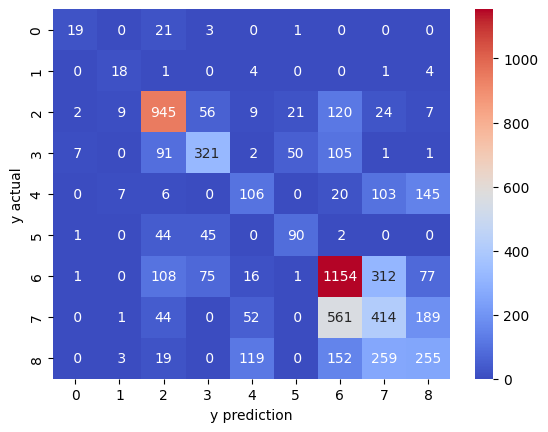

In [22]:
cm = confusion_matrix(y_test_s, y_pred_s)
sns.heatmap(cm, annot=True, cmap="coolwarm", fmt='2g')
plt.xlabel('y prediction')
plt.ylabel('y actual')
plt.show()

ROC AUC Score (Per Class): [0.98578994 0.99263061 0.95374462 0.94489622 0.90495697 0.96214866
 0.82039896 0.7624642  0.83651072]
Macro ROC AUC Score: 0.9071
Weighted ROC AUC Score: 0.8592


C:\Users\chris\AppData\Local\Temp\ipykernel_22748\4016092143.py:28: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='dashed', color='red')  # Random classifier line
C:\Users\chris\AppData\Local\Temp\ipykernel_22748\4016092143.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='dashed', color='red')  # Random classifier line


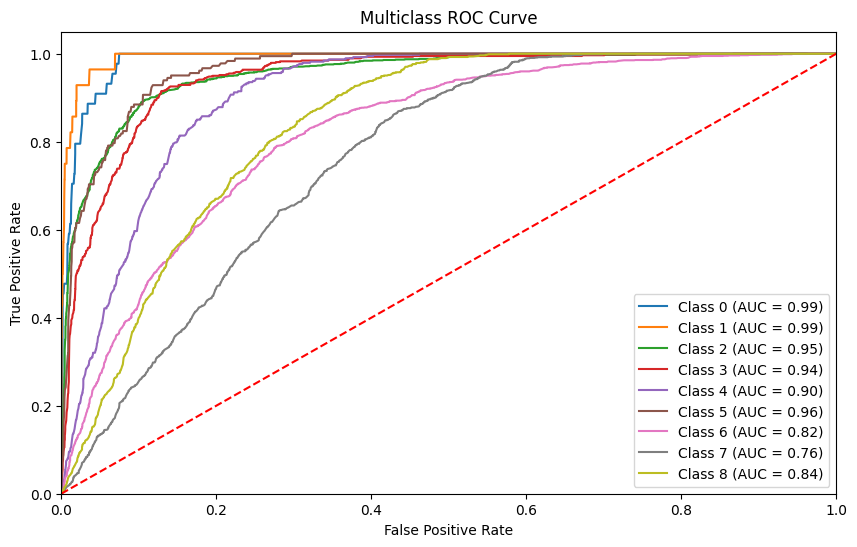

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass ROC AUC (One-vs-Rest)
y_test_binarized = label_binarize(y_test_s, classes=np.unique(y_test_s))

# Get predicted probabilities for each class
y_pred_proba = model_s.predict_proba(x_test_s)

# Compute ROC AUC score for each class
roc_auc_scores = roc_auc_score(y_test_binarized, y_pred_proba, average=None)

# Compute macro and weighted ROC AUC scores
macro_roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average="macro")
weighted_roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average="weighted")

print(f"ROC AUC Score (Per Class): {roc_auc_scores}")
print(f"Macro ROC AUC Score: {macro_roc_auc:.4f}")
print(f"Weighted ROC AUC Score: {weighted_roc_auc:.4f}")

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(y_pred_proba.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linestyle='dashed', color='red')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Full Model

In [24]:
x_train_f  , x_test_f , y_train_f, y_test_f = train_test_split (x_full ,y_full ,test_size = 0.3 , random_state = 0,stratify=y_full)

In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin

base_models_f = [
    ('logistic', Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(penalty='l1', solver='liblinear', C=0.5, max_iter=1000))
    ])),
]

model_f = StackingClassifier(
    estimators=base_models_f,
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    passthrough=True
)

model_f.fit(x_train_f, y_train_f)

C:\Users\chris\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\chris\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


StackingClassifier(estimators=[('logistic',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('lr',
                                                 LogisticRegression(C=0.5,
                                                                    max_iter=1000,
                                                                    penalty='l1',
                                                                    solver='liblinear'))]))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   passthrough=True)

In [26]:
y_pred_f=model_f.predict(x_test_f)
print(classification_report(y_test_f,y_pred_f))

              precision    recall  f1-score   support

           0       0.74      0.57      0.64        44
           1       0.65      0.61      0.63        28
           2       0.85      0.87      0.86      1193
           3       0.73      0.68      0.71       578
           4       0.71      0.66      0.68       387
           5       0.66      0.53      0.59       182
           6       0.73      0.79      0.76      1744
           7       0.62      0.65      0.64      1261
           8       0.59      0.51      0.54       807

    accuracy                           0.71      6224
   macro avg       0.70      0.65      0.67      6224
weighted avg       0.71      0.71      0.71      6224



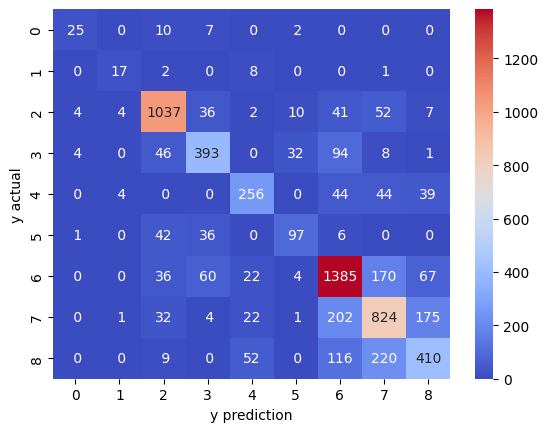

In [27]:
cm = confusion_matrix(y_test_f, y_pred_f)
sns.heatmap(cm, annot=True, cmap="coolwarm", fmt='2g')
plt.xlabel('y prediction')
plt.ylabel('y actual')
plt.show()

ROC AUC Score (Per Class): [0.98133642 0.97255142 0.98321921 0.96842852 0.97429611 0.98150674
 0.92586265 0.90529634 0.9120594 ]
Macro ROC AUC Score: 0.9561
Weighted ROC AUC Score: 0.9401


C:\Users\chris\AppData\Local\Temp\ipykernel_22748\689740349.py:28: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='dashed', color='red')  # Random classifier line
C:\Users\chris\AppData\Local\Temp\ipykernel_22748\689740349.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='dashed', color='red')  # Random classifier line


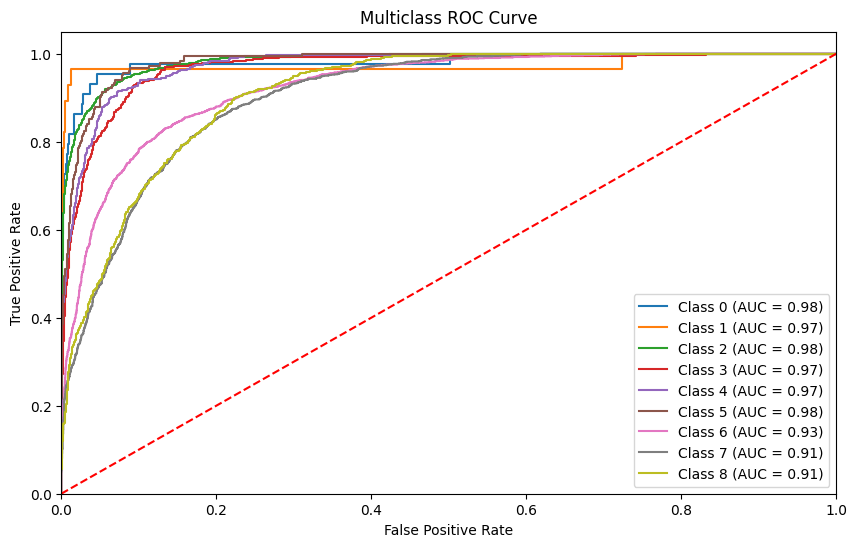

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass ROC AUC (One-vs-Rest)
y_test_binarized = label_binarize(y_test_f, classes=np.unique(y_test_f))

# Get predicted probabilities for each class
y_pred_proba = model_f.predict_proba(x_test_f)

# Compute ROC AUC score for each class
roc_auc_scores = roc_auc_score(y_test_binarized, y_pred_proba, average=None)

# Compute macro and weighted ROC AUC scores
macro_roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average="macro")
weighted_roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average="weighted")

print(f"ROC AUC Score (Per Class): {roc_auc_scores}")
print(f"Macro ROC AUC Score: {macro_roc_auc:.4f}")
print(f"Weighted ROC AUC Score: {weighted_roc_auc:.4f}")

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(y_pred_proba.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linestyle='dashed', color='red')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()
